In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_colum', None)
pd.set_option('display.max_colwidth',None)


import statsmodels.api as sm
from scipy import stats

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler,LabelEncoder

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
from sklearn.svm import SVC

In [3]:
df = pd.read_csv("Lc club data for imputation.csv",index_col = False)
df.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077501,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,Jan-16,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Default,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077430,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,Sep-13,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077175,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,Jan-16,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1076863,other,personel,917xx,CA,20.00,0.0,Feb-96,1.0,35.0,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,Jan-15,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN
4,4,1075269,1311441,5000,5000,5000.0,36 months,7.90,156.46,A,A4,Veolia Transportaton,3 years,RENT,36000.0,Source Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1075269,wedding,My wedding loan I promise to pay back,852xx,AZ,11.20,0.0,Nov-04,3.0,NaN,9.0,0.0,7963,28.3,12.0,f,0.0,0.0,5631.377753,5631.38,5000.00,631.38,0.00,0.00,0.00,Jan-15,161.03,Sep-15,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN


In [4]:
df.drop(['Unnamed: 0','id','member_id'],axis = 1,inplace = True)

In [5]:
df.shape

(254190, 51)

In [6]:
numeric = df.select_dtypes(include = [int, float])
cat  = df.select_dtypes('object')

In [7]:
cat.columns

Index(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'purpose', 'title', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type'],
      dtype='object')

In [8]:
cat.drop('loan_status',axis=1,inplace = True)

In [9]:
new_mv = pd.DataFrame({'mv_count':df.isnull().sum(),
                                'percent_missing':df.isnull().sum()/len(df) *100}
                              ).sort_values(by = ['percent_missing'], ascending = False).head(12)
new_mv.head(12)

,mv_count,percent_missing
mths_since_last_delinq,141446,55.645777
tot_coll_amt,63726,25.070223
tot_cur_bal,63726,25.070223
total_rev_hi_lim,63726,25.070223
emp_title,14010,5.511625
emp_length,9968,3.921476
last_pymnt_d,536,0.210866
revol_util,200,0.078681
collections_12_mths_ex_med,56,0.022031
last_credit_pull_d,21,0.008262


In [10]:
for row in ['title','emp_title','emp_length','last_pymnt_d','last_credit_pull_d']:
    df[row].fillna(df[row].mode()[0],inplace = True)

In [11]:
for row in new_mv.index[:12]:
    if df[row].dtypes in ['float64','int64']:
        df[row].fillna(df[row].median(),inplace = True)
    else:
        pass 
    

In [12]:
df.isnull().sum()

loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
emp_title                     0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
loan_status                   0
pymnt_plan                    0
url                           0
purpose                       0
title                         0
zip_code                      0
addr_state                    0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
inq_last_6mths                0
mths_since_last_delinq        0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
initial_

In [13]:
numeric = df.select_dtypes(include = [int, float])
cat  = df.select_dtypes('object')

In [14]:
for i in cat:
    print(i,df[i].nunique())

term 2
grade 7
sub_grade 35
emp_title 133189
emp_length 11
home_ownership 6
verification_status 3
issue_d 103
loan_status 2
pymnt_plan 2
url 254190
purpose 14
title 47943
zip_code 886
addr_state 51
earliest_cr_line 645
initial_list_status 2
last_pymnt_d 97
last_credit_pull_d 102
application_type 2


In [15]:
df.select_dtypes('object').describe().T

,count,unique,top,freq
term,254190,2,36 months,197373
grade,254190,7,B,76263
sub_grade,254190,35,B3,18106
emp_title,254190,133189,Manager,15969
emp_length,254190,11,10+ years,87224
home_ownership,254190,6,MORTGAGE,125342
verification_status,254190,3,Verified,93375
issue_d,254190,103,Oct-14,8808
loan_status,254190,2,Fully Paid,207723
pymnt_plan,254190,2,n,254188


df.drop(['pymnt_plan','url','title'],axis = 1, inplace = True)

In [16]:
cat.drop(['pymnt_plan','url','title'],axis = 1, inplace = True)

In [17]:
cat.drop(['loan_status'],axis =1,inplace = True)

df['loan_status

In [18]:
for column in cat:
    le = LabelEncoder()
    cat[column] = le.fit_transform(cat[column])

print(cat)

        term  grade  sub_grade  emp_title  emp_length  home_ownership  \
0          0      1          6      61813           1               5   
1          1      2         13      85868          10               5   
2          0      2         14      61813           1               5   
3          0      2         10       1500           1               5   
4          0      0          3     109400           3               5   
...      ...    ...        ...        ...         ...             ...   
254185     0      3         16     130613           1               1   
254186     0      0          0      25061          10               5   
254187     0      3         17      74699           2               5   
254188     0      1          5      57210           1               1   
254189     0      4         21      61813           1               4   

        verification_status  issue_d  purpose  zip_code  addr_state  \
0                         2       21        1       

In [19]:
cat.drop(['emp_title'],axis = 1,inplace = True)

In [20]:
cat

,term,grade,sub_grade,emp_length,home_ownership,verification_status,issue_d,purpose,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type
0,0,1,6,1,5,2,21,1,766,3,255,0,39,41,0
1,1,2,13,10,5,1,21,0,288,10,51,0,5,99,0
2,0,2,14,1,5,0,21,11,544,14,481,0,55,41,0
3,0,2,10,1,5,1,21,9,806,4,207,0,39,40,0
4,0,0,3,3,5,1,21,13,759,3,484,0,39,101,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254185,0,3,16,1,1,2,41,7,724,5,96,0,15,41,0
254186,0,0,0,10,5,0,41,2,304,9,511,1,48,59,0
254187,0,3,17,2,5,1,41,2,309,9,172,0,23,24,0
254188,0,1,5,1,1,2,41,0,845,4,594,0,56,83,0


In [21]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(numeric)
new_num = pd.DataFrame(x_scaled,columns = numeric.columns)
new_num

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,-1.053756,-1.051684,-1.040981,-0.709800,-1.042836,-0.825215,1.422752,-0.337469,0.138219,-0.096263,-1.623513,-0.329106,-0.081202,1.185384,-1.364944,-0.058156,-0.058155,-0.813176,-0.806014,-0.775105,-0.526091,-0.132323,-0.212454,-0.146516,-0.850979,-0.075849,0.0,-0.051544,-0.008369,-0.320526,-0.215300
1,-1.361132,-1.359907,-1.345429,0.339228,-1.463558,-0.723148,-1.996380,-0.337469,3.886744,-0.096263,-1.623513,-0.329106,-0.719234,-1.813571,-1.790497,-0.058156,-0.058155,-1.324837,-1.314583,-1.319845,-0.732117,-0.132323,-0.055590,-0.136762,-0.858041,-0.075849,0.0,-0.051544,-0.008369,-0.320526,-0.215300
2,-1.373427,-1.372236,-1.357730,0.495901,-1.363522,-1.025060,-1.005922,-0.337469,1.075351,-0.096263,-1.827877,-0.329106,-0.651542,1.782753,-1.279834,-0.058156,-0.058155,-1.114479,-1.104227,-1.086828,-0.650616,-0.132323,-0.212454,-0.146516,-0.785975,-0.075849,0.0,-0.051544,-0.008369,-0.320526,-0.215300
3,-0.439005,-0.435237,-0.422859,-0.064943,-0.322414,-0.396536,0.441275,-0.337469,0.138219,0.109123,-0.192966,-0.329106,-0.510611,-1.345363,1.018154,-0.058156,-0.058155,-0.141989,-0.131743,-0.175638,0.126119,2.985170,-0.212454,-0.146516,-0.825719,-0.075849,0.0,-0.051544,-0.008369,-0.320526,-0.215300
4,-1.053756,-1.051684,-1.037906,-1.334221,-1.069009,-0.621082,-0.687744,-0.337469,2.012482,-0.096263,-0.397330,-0.329106,-0.384455,-1.050714,-1.109612,-0.058156,-0.058155,-0.837396,-0.827145,-0.775105,-0.637201,-0.132323,-0.212454,-0.146516,-0.852418,-0.075849,0.0,-0.051544,-0.008369,-0.320526,-0.215300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254185,-1.152117,-1.150315,-1.136313,0.502713,-1.105022,-0.416949,2.613355,-0.337469,-0.798912,0.314509,0.420126,-0.329106,-0.118808,0.366019,1.699039,-0.058156,-0.058155,-1.323012,-1.312758,-1.294488,-0.769418,-0.132323,-0.212454,-0.146516,-0.854238,-0.075849,0.0,-0.051544,-0.008369,0.627530,-0.289127
254186,-0.343719,-0.339688,-0.327527,-1.758827,-0.368798,-0.314883,-0.428583,1.009535,-0.798912,-1.191653,-0.397330,-0.329106,-0.234402,-1.151621,-0.343616,-0.058156,-0.058155,-0.263719,-0.253472,-0.082721,-0.799018,-0.132323,-0.212454,-0.146516,0.408592,-0.075849,0.0,-0.051544,-0.008369,-0.738343,0.538511
254187,-0.903142,-0.900654,-0.887219,0.616244,-0.808058,-0.774181,0.259093,-0.337469,0.138219,-0.096263,-1.623513,-0.329106,-0.715553,1.746427,-1.790497,-0.058156,-0.058155,-0.687760,-0.677510,-0.628236,-0.543317,-0.132323,-0.212454,-0.146516,-0.214032,-0.075849,0.0,-0.051544,-0.008369,-0.860108,-1.011853
254188,-1.176707,-1.174973,-1.160915,-1.159383,-1.190971,-0.382927,-0.504278,-0.337469,-0.798912,-0.096263,0.011398,1.959629,-0.718540,-1.966950,0.422379,-0.058156,-0.058155,-0.992756,-0.982504,-0.894999,-0.866186,-0.132323,-0.212454,-0.146516,-0.377485,-0.075849,0.0,-0.051544,-0.008369,-0.780948,0.087778


In [22]:
new_df = new_num.merge(cat,left_index = True,right_index = True)
new_df

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,term,grade,sub_grade,emp_length,home_ownership,verification_status,issue_d,purpose,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type
0,-1.053756,-1.051684,-1.040981,-0.709800,-1.042836,-0.825215,1.422752,-0.337469,0.138219,-0.096263,-1.623513,-0.329106,-0.081202,1.185384,-1.364944,-0.058156,-0.058155,-0.813176,-0.806014,-0.775105,-0.526091,-0.132323,-0.212454,-0.146516,-0.850979,-0.075849,0.0,-0.051544,-0.008369,-0.320526,-0.215300,0,1,6,1,5,2,21,1,766,3,255,0,39,41,0
1,-1.361132,-1.359907,-1.345429,0.339228,-1.463558,-0.723148,-1.996380,-0.337469,3.886744,-0.096263,-1.623513,-0.329106,-0.719234,-1.813571,-1.790497,-0.058156,-0.058155,-1.324837,-1.314583,-1.319845,-0.732117,-0.132323,-0.055590,-0.136762,-0.858041,-0.075849,0.0,-0.051544,-0.008369,-0.320526,-0.215300,1,2,13,10,5,1,21,0,288,10,51,0,5,99,0
2,-1.373427,-1.372236,-1.357730,0.495901,-1.363522,-1.025060,-1.005922,-0.337469,1.075351,-0.096263,-1.827877,-0.329106,-0.651542,1.782753,-1.279834,-0.058156,-0.058155,-1.114479,-1.104227,-1.086828,-0.650616,-0.132323,-0.212454,-0.146516,-0.785975,-0.075849,0.0,-0.051544,-0.008369,-0.320526,-0.215300,0,2,14,1,5,0,21,11,544,14,481,0,55,41,0
3,-0.439005,-0.435237,-0.422859,-0.064943,-0.322414,-0.396536,0.441275,-0.337469,0.138219,0.109123,-0.192966,-0.329106,-0.510611,-1.345363,1.018154,-0.058156,-0.058155,-0.141989,-0.131743,-0.175638,0.126119,2.985170,-0.212454,-0.146516,-0.825719,-0.075849,0.0,-0.051544,-0.008369,-0.320526,-0.215300,0,2,10,1,5,1,21,9,806,4,207,0,39,40,0
4,-1.053756,-1.051684,-1.037906,-1.334221,-1.069009,-0.621082,-0.687744,-0.337469,2.012482,-0.096263,-0.397330,-0.329106,-0.384455,-1.050714,-1.109612,-0.058156,-0.058155,-0.837396,-0.827145,-0.775105,-0.637201,-0.132323,-0.212454,-0.146516,-0.852418,-0.075849,0.0,-0.051544,-0.008369,-0.320526,-0.215300,0,0,3,3,5,1,21,13,759,3,484,0,39,101,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254185,-1.152117,-1.150315,-1.136313,0.502713,-1.105022,-0.416949,2.613355,-0.337469,-0.798912,0.314509,0.420126,-0.329106,-0.118808,0.366019,1.699039,-0.058156,-0.058155,-1.323012,-1.312758,-1.294488,-0.769418,-0.132323,-0.212454,-0.146516,-0.854238,-0.075849,0.0,-0.051544,-0.008369,0.627530,-0.289127,0,3,16,1,1,2,41,7,724,5,96,0,15,41,0
254186,-0.343719,-0.339688,-0.327527,-1.758827,-0.368798,-0.314883,-0.428583,1.009535,-0.798912,-1.191653,-0.397330,-0.329106,-0.234402,-1.151621,-0.343616,-0.058156,-0.058155,-0.263719,-0.253472,-0.082721,-0.799018,-0.132323,-0.212454,-0.146516,0.408592,-0.075849,0.0,-0.051544,-0.008369,-0.738343,0.538511,0,0,0,10,5,0,41,2,304,9,511,1,48,59,0
254187,-0.903142,-0.900654,-0.887219,0.616244,-0.808058,-0.774181,0.259093,-0.337469,0.138219,-0.096263,-1.623513,-0.329106,-0.715553,1.746427,-1.790497,-0.058156,-0.058155,-0.687760,-0.677510,-0.628236,-0.543317,-0.132323,-0.212454,-0.146516,-0.214032,-0.075849,0.0,-0.051544,-0.008369,-0.860108,-1.011853,0,3,17,2,5,1,41,2,309,9,172,0,23,24,0
254188,-1.176707,-1.174973,-1.160915,-1.159383,-1.190971,-0.382927,-0.504278,-0.337469,-0.798912,-0.096263,0.011398,1.959629,-0.718540,-1.966950,0.422379,-0.058156,-0.058155,-0.992756,-0.982504,-0.894999,-0.866186,-0.132323,-0.212454,-0.146516,-0.377485,-0.075849,0.0,-0.051544,-0.008369,-0.780948,0.087778,0,1,5,1,1,2,41,0,845,4,594,0,56,83,0


In [23]:
new_df.shape

(254190, 46)

In [24]:
new_df.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med', 'policy_code',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'issue_d', 'purpose', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type'],
      dtype='object')

new_df.drop(['id','member_id'],axis = 1,inplace = True)

In [25]:
df['loan_status'].replace({'Fully Paid':0,'Default':1},inplace = True)

In [26]:
X = new_df
y = df['loan_status']

In [27]:
new_df

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,term,grade,sub_grade,emp_length,home_ownership,verification_status,issue_d,purpose,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type
0,-1.053756,-1.051684,-1.040981,-0.709800,-1.042836,-0.825215,1.422752,-0.337469,0.138219,-0.096263,-1.623513,-0.329106,-0.081202,1.185384,-1.364944,-0.058156,-0.058155,-0.813176,-0.806014,-0.775105,-0.526091,-0.132323,-0.212454,-0.146516,-0.850979,-0.075849,0.0,-0.051544,-0.008369,-0.320526,-0.215300,0,1,6,1,5,2,21,1,766,3,255,0,39,41,0
1,-1.361132,-1.359907,-1.345429,0.339228,-1.463558,-0.723148,-1.996380,-0.337469,3.886744,-0.096263,-1.623513,-0.329106,-0.719234,-1.813571,-1.790497,-0.058156,-0.058155,-1.324837,-1.314583,-1.319845,-0.732117,-0.132323,-0.055590,-0.136762,-0.858041,-0.075849,0.0,-0.051544,-0.008369,-0.320526,-0.215300,1,2,13,10,5,1,21,0,288,10,51,0,5,99,0
2,-1.373427,-1.372236,-1.357730,0.495901,-1.363522,-1.025060,-1.005922,-0.337469,1.075351,-0.096263,-1.827877,-0.329106,-0.651542,1.782753,-1.279834,-0.058156,-0.058155,-1.114479,-1.104227,-1.086828,-0.650616,-0.132323,-0.212454,-0.146516,-0.785975,-0.075849,0.0,-0.051544,-0.008369,-0.320526,-0.215300,0,2,14,1,5,0,21,11,544,14,481,0,55,41,0
3,-0.439005,-0.435237,-0.422859,-0.064943,-0.322414,-0.396536,0.441275,-0.337469,0.138219,0.109123,-0.192966,-0.329106,-0.510611,-1.345363,1.018154,-0.058156,-0.058155,-0.141989,-0.131743,-0.175638,0.126119,2.985170,-0.212454,-0.146516,-0.825719,-0.075849,0.0,-0.051544,-0.008369,-0.320526,-0.215300,0,2,10,1,5,1,21,9,806,4,207,0,39,40,0
4,-1.053756,-1.051684,-1.037906,-1.334221,-1.069009,-0.621082,-0.687744,-0.337469,2.012482,-0.096263,-0.397330,-0.329106,-0.384455,-1.050714,-1.109612,-0.058156,-0.058155,-0.837396,-0.827145,-0.775105,-0.637201,-0.132323,-0.212454,-0.146516,-0.852418,-0.075849,0.0,-0.051544,-0.008369,-0.320526,-0.215300,0,0,3,3,5,1,21,13,759,3,484,0,39,101,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254185,-1.152117,-1.150315,-1.136313,0.502713,-1.105022,-0.416949,2.613355,-0.337469,-0.798912,0.314509,0.420126,-0.329106,-0.118808,0.366019,1.699039,-0.058156,-0.058155,-1.323012,-1.312758,-1.294488,-0.769418,-0.132323,-0.212454,-0.146516,-0.854238,-0.075849,0.0,-0.051544,-0.008369,0.627530,-0.289127,0,3,16,1,1,2,41,7,724,5,96,0,15,41,0
254186,-0.343719,-0.339688,-0.327527,-1.758827,-0.368798,-0.314883,-0.428583,1.009535,-0.798912,-1.191653,-0.397330,-0.329106,-0.234402,-1.151621,-0.343616,-0.058156,-0.058155,-0.263719,-0.253472,-0.082721,-0.799018,-0.132323,-0.212454,-0.146516,0.408592,-0.075849,0.0,-0.051544,-0.008369,-0.738343,0.538511,0,0,0,10,5,0,41,2,304,9,511,1,48,59,0
254187,-0.903142,-0.900654,-0.887219,0.616244,-0.808058,-0.774181,0.259093,-0.337469,0.138219,-0.096263,-1.623513,-0.329106,-0.715553,1.746427,-1.790497,-0.058156,-0.058155,-0.687760,-0.677510,-0.628236,-0.543317,-0.132323,-0.212454,-0.146516,-0.214032,-0.075849,0.0,-0.051544,-0.008369,-0.860108,-1.011853,0,3,17,2,5,1,41,2,309,9,172,0,23,24,0
254188,-1.176707,-1.174973,-1.160915,-1.159383,-1.190971,-0.382927,-0.504278,-0.337469,-0.798912,-0.096263,0.011398,1.959629,-0.718540,-1.966950,0.422379,-0.058156,-0.058155,-0.992756,-0.982504,-0.894999,-0.866186,-0.132323,-0.212454,-0.146516,-0.377485,-0.075849,0.0,-0.051544,-0.008369,-0.780948,0.087778,0,1,5,1,1,2,41,0,845,4,594,0,56,83,0


X = sm.add_constant(X)

# Create the model
logit_model = sm.Logit(y, X)

# Fit the model
result = logit_model.fit(maxiter = 500)

# Print the summary of the model
print(result.summary())

y

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 7)
lr = LogisticRegression()
lr.fit(X_train,y_train)
pred = lr.predict(X_test)

In [30]:
from sklearn import metrics

In [31]:
metrics.confusion_matrix(y_test,pred)

array([[60668,  1621],
       [ 2300, 11668]], dtype=int64)

In [32]:
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     62289
           1       0.88      0.84      0.86     13968

    accuracy                           0.95     76257
   macro avg       0.92      0.90      0.91     76257
weighted avg       0.95      0.95      0.95     76257



svc = SVC()
svc.fit(X_train,y_train)
svc_pred = rfc.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test,svc_pred))

In [166]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
rfc_pred = rfc.predict(X_test)

In [167]:
print(metrics.classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     62289
           1       1.00      0.99      0.99     13968

    accuracy                           1.00     76257
   macro avg       1.00      0.99      1.00     76257
weighted avg       1.00      1.00      1.00     76257



In [168]:
metrics.confusion_matrix(y_test,rfc_pred)

array([[62287,     2],
       [  163, 13805]], dtype=int64)

Here we, are got True Negative of 62287, false positive only 2, false negative 163, and True Poitive 13805.

In [188]:
precision = round(13805/(13805+2),4)      # Precision is the ratio of True positive value to the total predicted positive values
precision

0.9999

In [190]:
recall = round(13805/(13805+163),4)       # Recall is the ratio of True positive value by to total number of actual positive values
recall                                    #Also, known as True Poitive Rate , Sensitivity

0.9883

In [169]:
metrics.accuracy_score(y_test,rfc_pred)

0.99783626421181

In [170]:
df.loan_status.unique()

array([0, 1], dtype=int64)

In [171]:
df.loan_status.value_counts()

loan_status
0    207723
1     46467
Name: count, dtype: int64

In [77]:
new_df.loan_status

0         1
1         0
2         1
3         1
4         1
         ..
254185    0
254186    1
254187    1
254188    1
254189    0
Name: loan_status, Length: 254190, dtype: int32

rfc.feature_importances_

rfc.feature_names_in_

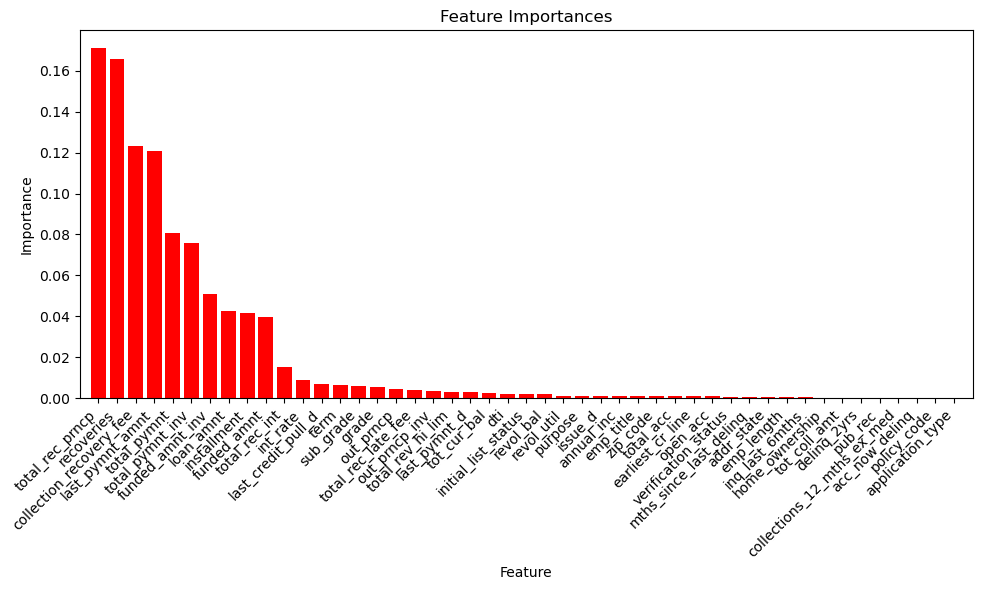

In [174]:
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
sorted_feature_names = [X_train.columns[i] for i in indices]


plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices],color="r", align="center")
plt.xticks(range(X_train.shape[1]), sorted_feature_names, rotation=45, ha="right")
plt.xlim([-1, X_train.shape[1]])
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()  
plt.show()

In [191]:
df['last_credit_pull_d']

0         Jan-16
1         Sep-13
2         Jan-16
3         Jan-15
4         Sep-15
           ...  
254185    Jan-16
254186    Jun-15
254187    Dec-15
254188    Nov-15
254189    Jan-16
Name: last_credit_pull_d, Length: 254190, dtype: object

<Axes: >

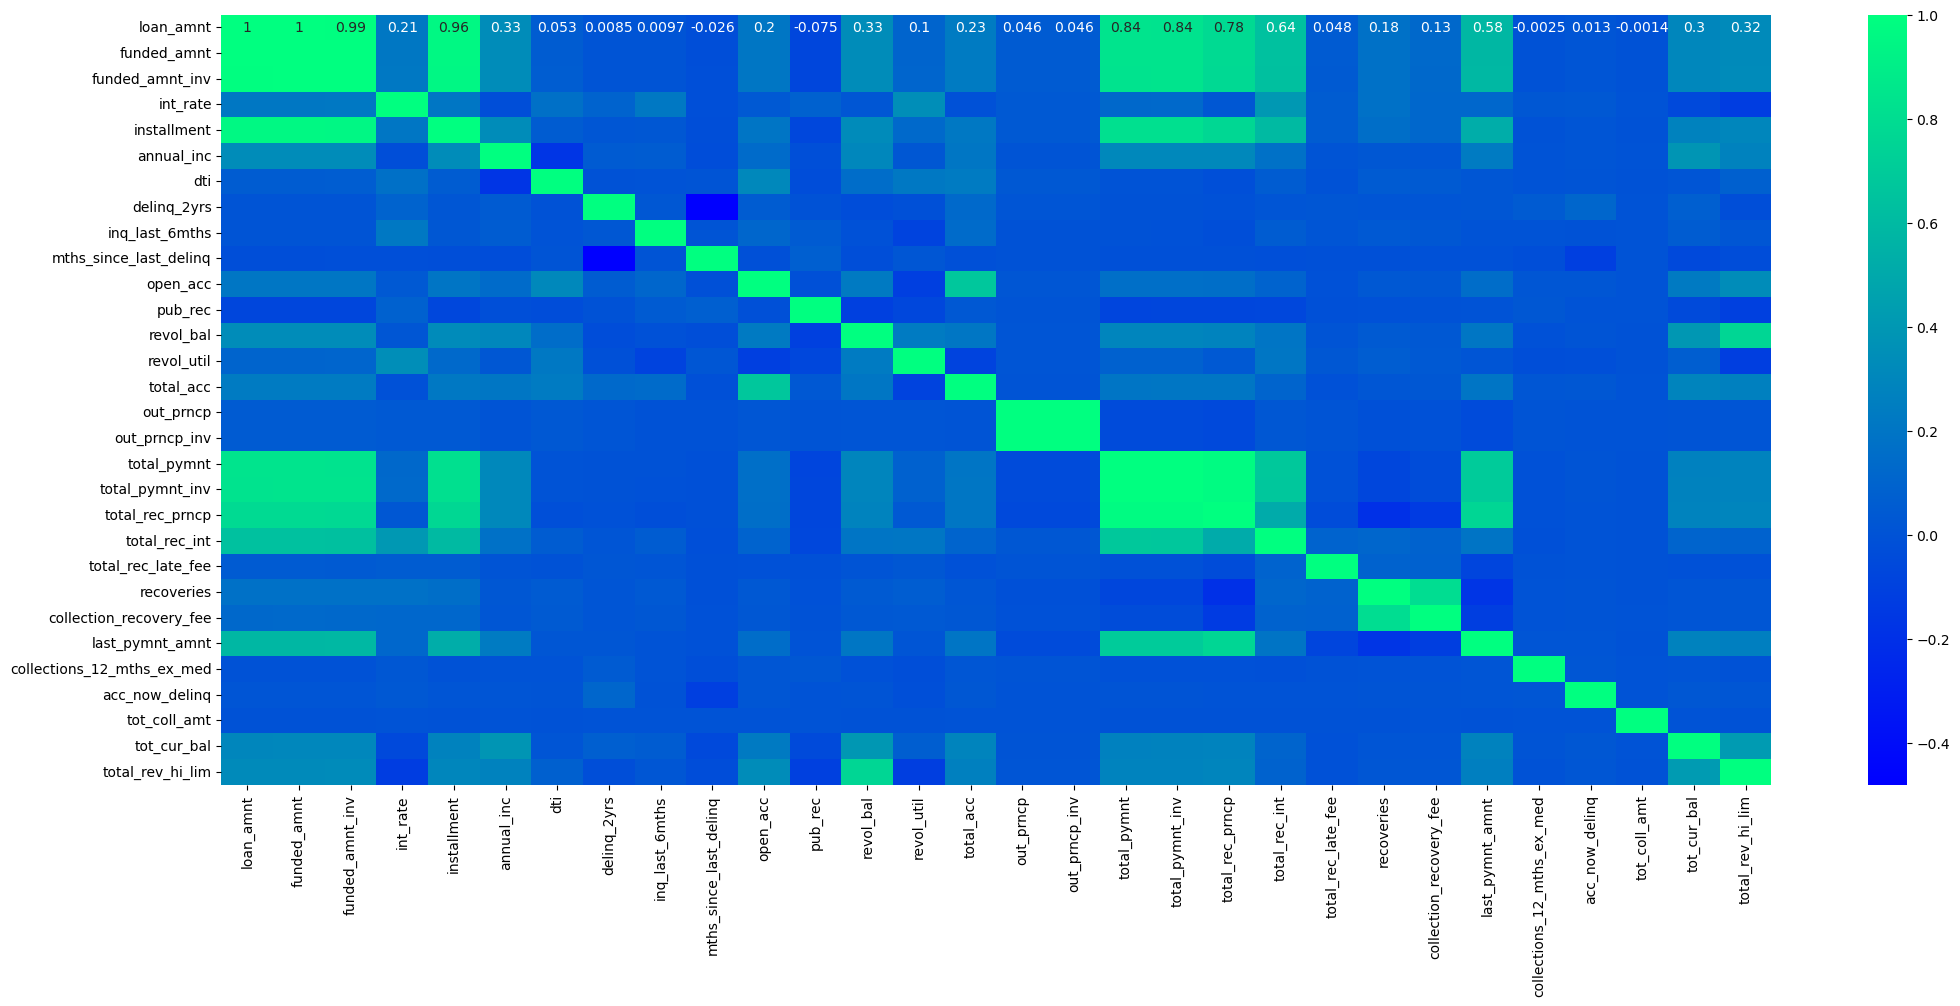

In [183]:
#numeric.drop('policy_code',axis = 1,inplace = True)
plt.figure(figsize = (25,10))
sns.heatmap(numeric.corr(),annot  = True,cmap = 'winter')

In [195]:
rfc.decision_path()

TypeError: BaseForest.decision_path() missing 1 required positional argument: 'X'

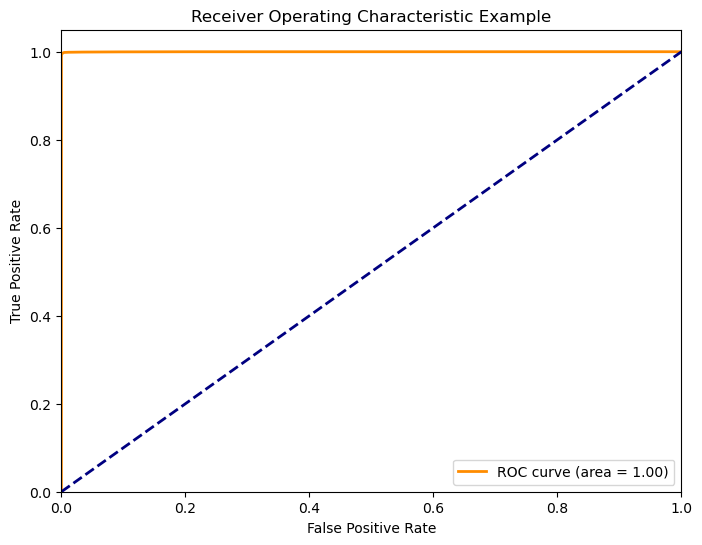

In [184]:
from sklearn.metrics import roc_curve, auc
y_scores = rfc.predict_proba(X_test)[:, 1]  
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Example')
plt.legend(loc="lower right")
plt.show()


## feature selection
## applying RFE
from sklearn.feature_selection import RFE
import numpy as np
model = LogisticRegression()
#no of features
nof_list=np.arange(1,48)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LogisticRegression()
    rfe = RFE(estimator = model,n_features_to_select = nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

In [ ]:
sns.pairplot(df.select_dtypes(np.number))

In [199]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import VarianceThreshold

# Assuming 'X' is your feature DataFrame

# Remove zero variance features
sel = VarianceThreshold(threshold=0)
X_reduced = sel.fit_transform(X)
X_reduced = pd.DataFrame(X_reduced, columns=X.columns[sel.get_support()])

# Calculate VIF
vif_data = pd.DataFrame()
#vif_data["feature"] = X_reduced.columns
#vif_data["VIF"] = [variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])]

#print(vif_data)


In [ ]:
X_reduced

In [198]:
sel

VarianceThreshold(threshold=0)